In [2]:
import os
import glob
import json
import numpy as np
import cv2

from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D,Flatten,Dropout,BatchNormalization,Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint


# Load Data

In [3]:
train_path='/content/drive/MyDrive/Colab Notebooks/brain-tumor/train'
test_path="/content/drive/MyDrive/Colab Notebooks/brain-tumor/test"
valid_path='/content/drive/MyDrive/Colab Notebooks/brain-tumor/valid'

## Load Image

In [4]:
train_data=[image for image in os.listdir(train_path)]
test_data=[image for image in os.listdir(test_path)]
valid_data=[image for image in os.listdir(valid_path)]

## Load annotation

In [5]:
train_annotation=glob.glob(os.path.join(train_path,"*.json"))
test_annotation=glob.glob(os.path.join(test_path,"*.json"))
valid_annotation=glob.glob(os.path.join(valid_path,"*.json"))


In [6]:
train_annotation=json.load(open(train_annotation[0]))
test_annotation=json.load(open(test_annotation[0]))
valid_annotation=json.load(open(valid_annotation[0]))


# Show Image and annotaiton Random Image

Loading image: /content/drive/MyDrive/Colab Notebooks/brain-tumor/train/2_jpg.rf.fded76c07e967829600f3509288fdfe0.jpg
Loading image: /content/drive/MyDrive/Colab Notebooks/brain-tumor/train/2_jpg.rf.fded76c07e967829600f3509288fdfe0.jpg
Loading image: /content/drive/MyDrive/Colab Notebooks/brain-tumor/train/2_jpg.rf.fded76c07e967829600f3509288fdfe0.jpg


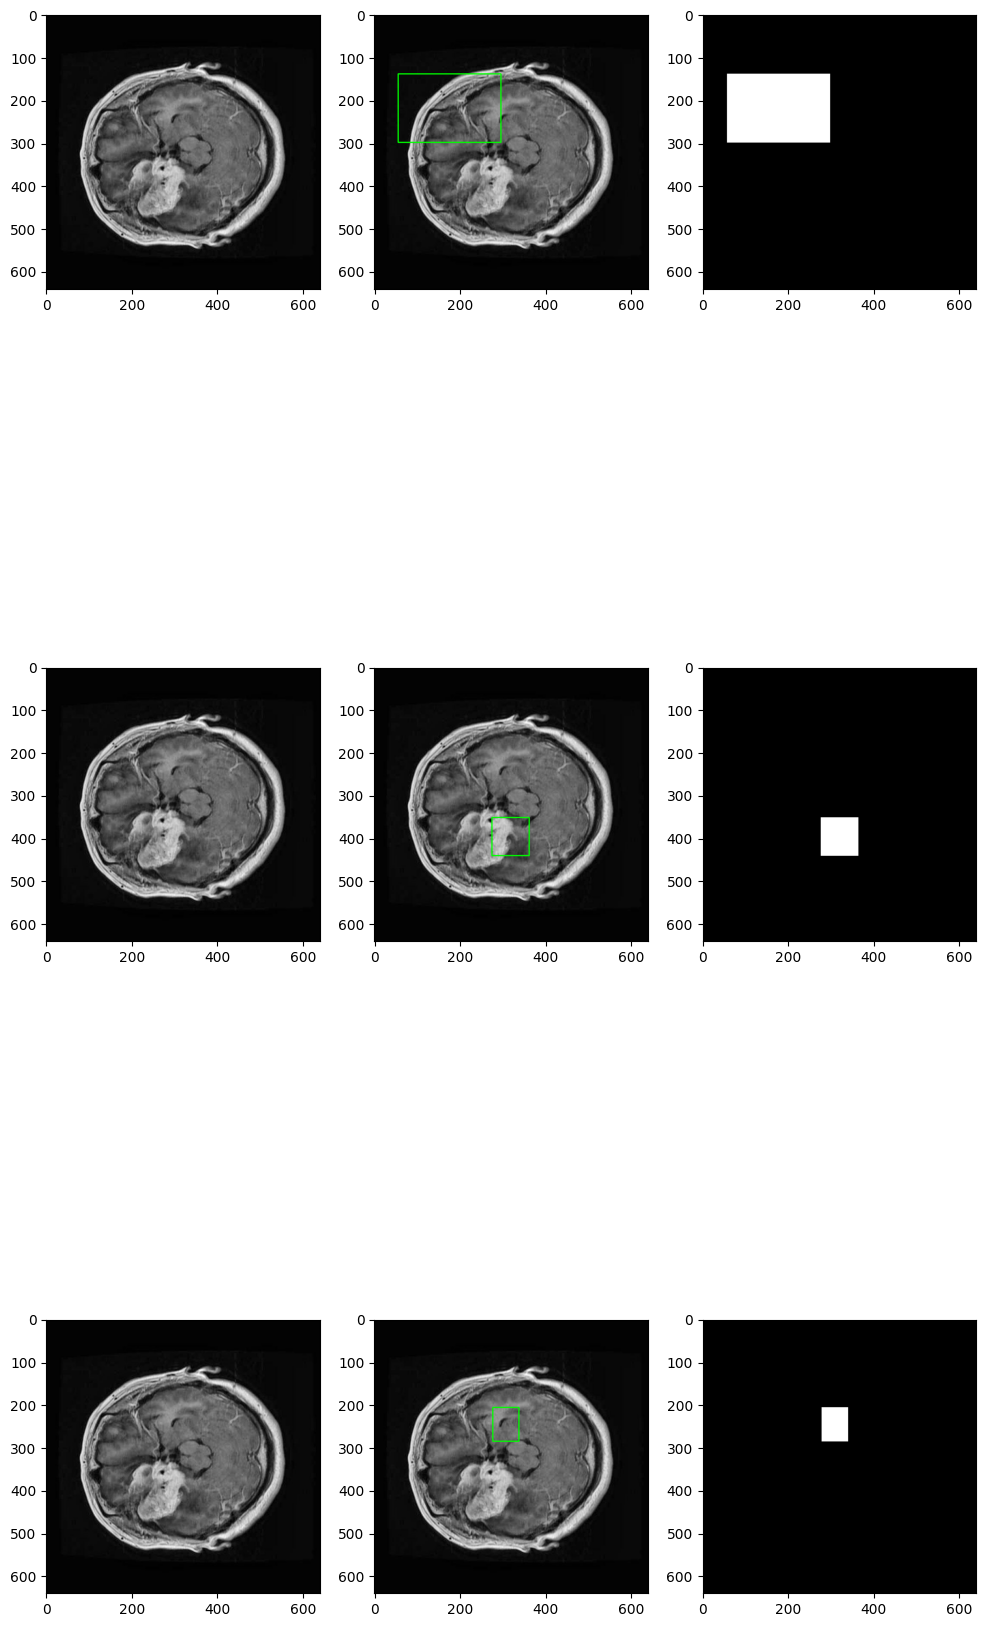

In [15]:
import matplotlib.pyplot as plt

def visualize_random_images(n=3):
    indices = np.random.randint(0, len(train_annotation['images']), size=n)


    images = [train_annotation['images'][i] for i in indices]
    annotations = [train_annotation['annotations'][i] for i in indices]

    j = 1
    plt.figure(figsize=(12, 4 * 2 * n))

    for img, ann in zip(images, annotations):
        plt.subplot(n, 3, j)
        j += 1

        image_path = os.path.join(train_path, '2_jpg.rf.fded76c07e967829600f3509288fdfe0.jpg')
        print(f"Loading image: {image_path}")

        image = cv2.imread(image_path)

        if image is None:
            print(f"Error: Image not found or failed to load: {image_path}")
            continue


        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)

        segmentation = ann['segmentation']
        segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2)


        cv2.polylines(image, [segmentation], isClosed=True, color=(0, 255, 0), thickness=2)

        plt.subplot(n, 3, j)
        plt.imshow(image)
        j += 1

        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillPoly(mask, [segmentation], color=1)

        plt.subplot(n, 3, j)
        plt.imshow(mask, cmap='gray')
        j += 1

visualize_random_images()


# Apply Mask for all Image

In [23]:
def load_annotations(annotation_file):
    """Load annotations from a COCO format JSON file."""
    with open(annotation_file, 'r') as file:
        annotations = json.load(file)
    return annotations

def create_mask(image, segmentation):
    """Create a binary mask from segmentation data."""
    mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    segmentation = np.array(segmentation, dtype=np.int32).reshape(-1, 2)
    cv2.fillPoly(mask, [segmentation], color=(255))
    return mask

def _train_masks():
    print('Processing train masks...')
    mask_dir = '/content/drive/MyDrive/Colab Notebooks/brain-tumor/train_masks/'
    os.makedirs(mask_dir, exist_ok=True)

    train_annotation = load_annotations('/content/drive/MyDrive/Colab Notebooks/brain-tumor/train/_annotations.coco.json')
    total_images = len(train_annotation['images'])
    done = 0

    for img, ann in zip(train_annotation['images'], train_annotation['annotations']):
        image_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/brain-tumor/train/', img['file_name'])
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error processing image {img['file_name']}: Failed to load image.")
            continue

        mask = create_mask(image, ann['segmentation'])
        mask_path = os.path.join(mask_dir, img['file_name'])
        cv2.imwrite(mask_path, mask)
        done += 1
        print(f"Processed train mask {done}/{total_images}")

def _test_masks():
    print('Processing test masks...')
    mask_dir = '/content/drive/MyDrive/Colab Notebooks/brain-tumor/test_masks/'
    os.makedirs(mask_dir, exist_ok=True)

    test_annotation = load_annotations('/content/drive/MyDrive/Colab Notebooks/brain-tumor/test/_annotations.coco.json')
    total_images = len(test_annotation['images'])
    done = 0

    for img, ann in zip(test_annotation['images'], test_annotation['annotations']):
        image_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/brain-tumor/test/', img['file_name'])
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error processing image {img['file_name']}: Failed to load image.")
            continue

        mask = create_mask(image, ann['segmentation'])
        mask_path = os.path.join(mask_dir, img['file_name'])
        cv2.imwrite(mask_path, mask)
        done += 1
        print(f"Processed test mask {done}/{total_images}")

def _val_masks():
    print('Processing validation masks...')
    mask_dir = '/content/drive/MyDrive/Colab Notebooks/brain-tumor/val_masks/'
    os.makedirs(mask_dir, exist_ok=True)

    val_annotation = load_annotations('/content/drive/MyDrive/Colab Notebooks/brain-tumor/valid/_annotations.coco.json')
    total_images = len(val_annotation['images'])
    done = 0

    for img, ann in zip(val_annotation['images'], val_annotation['annotations']):
        image_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/brain-tumor/valid/', img['file_name'])
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error processing image {img['file_name']}: Failed to load image.")
            continue

        mask = create_mask(image, ann['segmentation'])
        mask_path = os.path.join(mask_dir, img['file_name'])
        cv2.imwrite(mask_path, mask)
        done += 1
        print(f"Processed validation mask {done}/{total_images}")

def make_masks():
    threads = []
    threads.append(Thread(target=_train_masks))
    threads.append(Thread(target=_test_masks))
    threads.append(Thread(target=_val_masks))

    for t in threads:
        t.start()
    for t in threads:
        t.join()
    print('Mask creation complete.')

make_masks()

Processing train masks...Processing test masks...

Processing validation masks...
Processed test mask 1/215
Processed validation mask 1/429
Processed train mask 1/1502
Processed test mask 2/215
Processed train mask 2/1502
Processed validation mask 2/429
Processed test mask 3/215
Processed train mask 3/1502
Processed test mask 4/215
Processed validation mask 3/429
Processed train mask 4/1502
Processed test mask 5/215
Processed validation mask 4/429
Processed test mask 6/215
Processed train mask 5/1502
Processed validation mask 5/429
Processed test mask 7/215
Processed train mask 6/1502
Processed test mask 8/215
Processed validation mask 6/429
Processed test mask 9/215
Processed train mask 7/1502
Processed validation mask 7/429
Processed test mask 10/215
Processed test mask 11/215
Processed validation mask 8/429
Processed train mask 8/1502
Processed test mask 12/215
Processed test mask 13/215
Processed train mask 9/1502
Processed test mask 14/215
Processed validation mask 9/429
Processed

# Split Data

In [24]:
def load_data():
    target_size = (128, 128)
    train_mask_dir = '/content/drive/MyDrive/Colab Notebooks/brain-tumor/train_masks/'

    # Load training annotations
    train_annotation = load_annotations('/content/drive/MyDrive/Colab Notebooks/brain-tumor/train/_annotations.coco.json')

    X_train = []
    y_train = []

    for image in train_annotation['images']:
        image_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/brain-tumor/train/', image['file_name'])
        mask_path = os.path.join(train_mask_dir, image['file_name'])

        # Load and resize image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Failed to load image {image['file_name']}. Skipping...")
            continue

        img_resized = cv2.resize(img, target_size)
        X_train.append(img_resized)

        # Load and resize mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Warning: Failed to load mask for {image['file_name']}. Skipping...")
            continue

        mask_resized = cv2.resize(mask, target_size)
        y_train.append(mask_resized)

    X_train = np.array(X_train)
    y_train = np.expand_dims(np.array(y_train), axis=-1)

    # Normalize the images and convert masks to binary
    X_train = X_train.astype('float32') / 255.0
    y_train = y_train.astype('float32') / 255.0
    y_train = (y_train > 0.5).astype(np.float32)

    # Load validation data
    val_mask_dir = '/content/drive/MyDrive/Colab Notebooks/brain-tumor/val_masks/'
    valid_annotation = load_annotations('/content/drive/MyDrive/Colab Notebooks/brain-tumor/valid/_annotations.coco.json')

    X_val = []
    y_val = []

    for image in valid_annotation['images']:
        image_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/brain-tumor/valid/', image['file_name'])
        mask_path = os.path.join(val_mask_dir, image['file_name'])

        # Load and resize validation image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Failed to load validation image {image['file_name']}. Skipping...")
            continue

        img_resized = cv2.resize(img, target_size)
        X_val.append(img_resized)

        # Load and resize validation mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Warning: Failed to load validation mask for {image['file_name']}. Skipping...")
            continue

        mask_resized = cv2.resize(mask, target_size)
        y_val.append(mask_resized)

    X_val = np.array(X_val)
    y_val = np.expand_dims(np.array(y_val), axis=-1)

    # Normalize the validation images and convert masks to binary
    X_val = X_val.astype('float32') / 255.0
    y_val = y_val.astype('float32') / 255.0
    y_val = (y_val > 0.5).astype(np.float32)

    return X_train, y_train, X_val, y_val


def load_test_data():
    target_size = (128, 128)
    test_mask_dir = '/content/drive/MyDrive/Colab Notebooks/brain-tumor/test_masks/'

    # Load test annotations
    test_annotation = load_annotations('/content/drive/MyDrive/Colab Notebooks/brain-tumor/test/_annotations.coco.json')

    X_test = []
    y_test = []

    for image in test_annotation['images']:
        image_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/brain-tumor/test/', image['file_name'])
        mask_path = os.path.join(test_mask_dir, image['file_name'])

        # Load and resize test image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Failed to load test image {image['file_name']}. Skipping...")
            continue

        img_resized = cv2.resize(img, target_size)
        X_test.append(img_resized)

        # Load and resize test mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Warning: Failed to load test mask for {image['file_name']}. Skipping...")
            continue

        mask_resized = cv2.resize(mask, target_size)
        y_test.append(mask_resized)

    X_test = np.array(X_test)
    y_test = np.expand_dims(np.array(y_test), axis=-1)

    # Normalize the test images and convert masks to binary
    X_test = X_test.astype('float32') / 255.0
    y_test = y_test.astype('float32') / 255.0
    y_test = (y_test > 0.5).astype(np.float32)

    return X_test, y_test

In [25]:
X_train,y_train,X_val,y_val = load_data()


# Segmentation Model

In [26]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

In [27]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

In [28]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

In [29]:
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [30]:
unet_model = build_unet_model()

In [31]:
unet_model.compile(optimizer="adam",loss="BinaryCrossentropy",metrics=["accuracy"])

In [32]:
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64, 64)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 128)    │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 16, 16, 256)    │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 8, 8, 512)      │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 34,513,345 (131.66 MB)

 Trainable params: 34,513,345 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_loss',patience=5)



callbacks_list = [earlystop]

unet_model.fit(X_train,y_train,epochs=50,validation_data=(X_val,y_val),callbacks=callbacks_list)

Epoch 1/50
 1/47 ━━━━━━━━━━━━━━━━━━━━ 1:00:38 79s/step - accuracy: 0.1304 - loss: 0.8740

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prediciton

In [ ]:
def predict(image_path, model, threshold=0.5):

    # Read and preprocess the image
    image = cv2.imread(image_path)
    print("Original Image Shape:", image.shape)

    # Resize the image to match model's expected sizing
    resized_image = cv2.resize(image, (128, 128))
    print("Resized Image Shape:", resized_image.shape)

    # Expand dimensions to match the batch size used by the model
    input_image = np.expand_dims(resized_image, axis=0)

    # Preprocess input (normalize to [0, 1] range)
    input_image = input_image.astype('float32') / 255.0

    # Perform prediction
    pred_mask = model.predict(input_image)

    # Apply threshold to prediction mask
    pred_mask[pred_mask >= threshold] = 1  # set values >= threshold to 1 (foreground)
    pred_mask[pred_mask < threshold] = 0   # set values < threshold to 0 (background)

    # If your model outputs probabilities, you might need to squeeze the mask
    pred_mask = np.squeeze(pred_mask, axis=0)

    # Count number of pixels where mask is 1 (foreground)
    num_pixels = np.count_nonzero(pred_mask)
    print("shape mask",pred_mask.shape)
    return pred_mask


# Show Result

Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
shape mask (128, 128, 1)
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
shape mask (128, 128, 1)
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
shape mask (128, 128, 1)
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
shape mask (128, 128, 1)
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
shape mask (128, 128, 1)


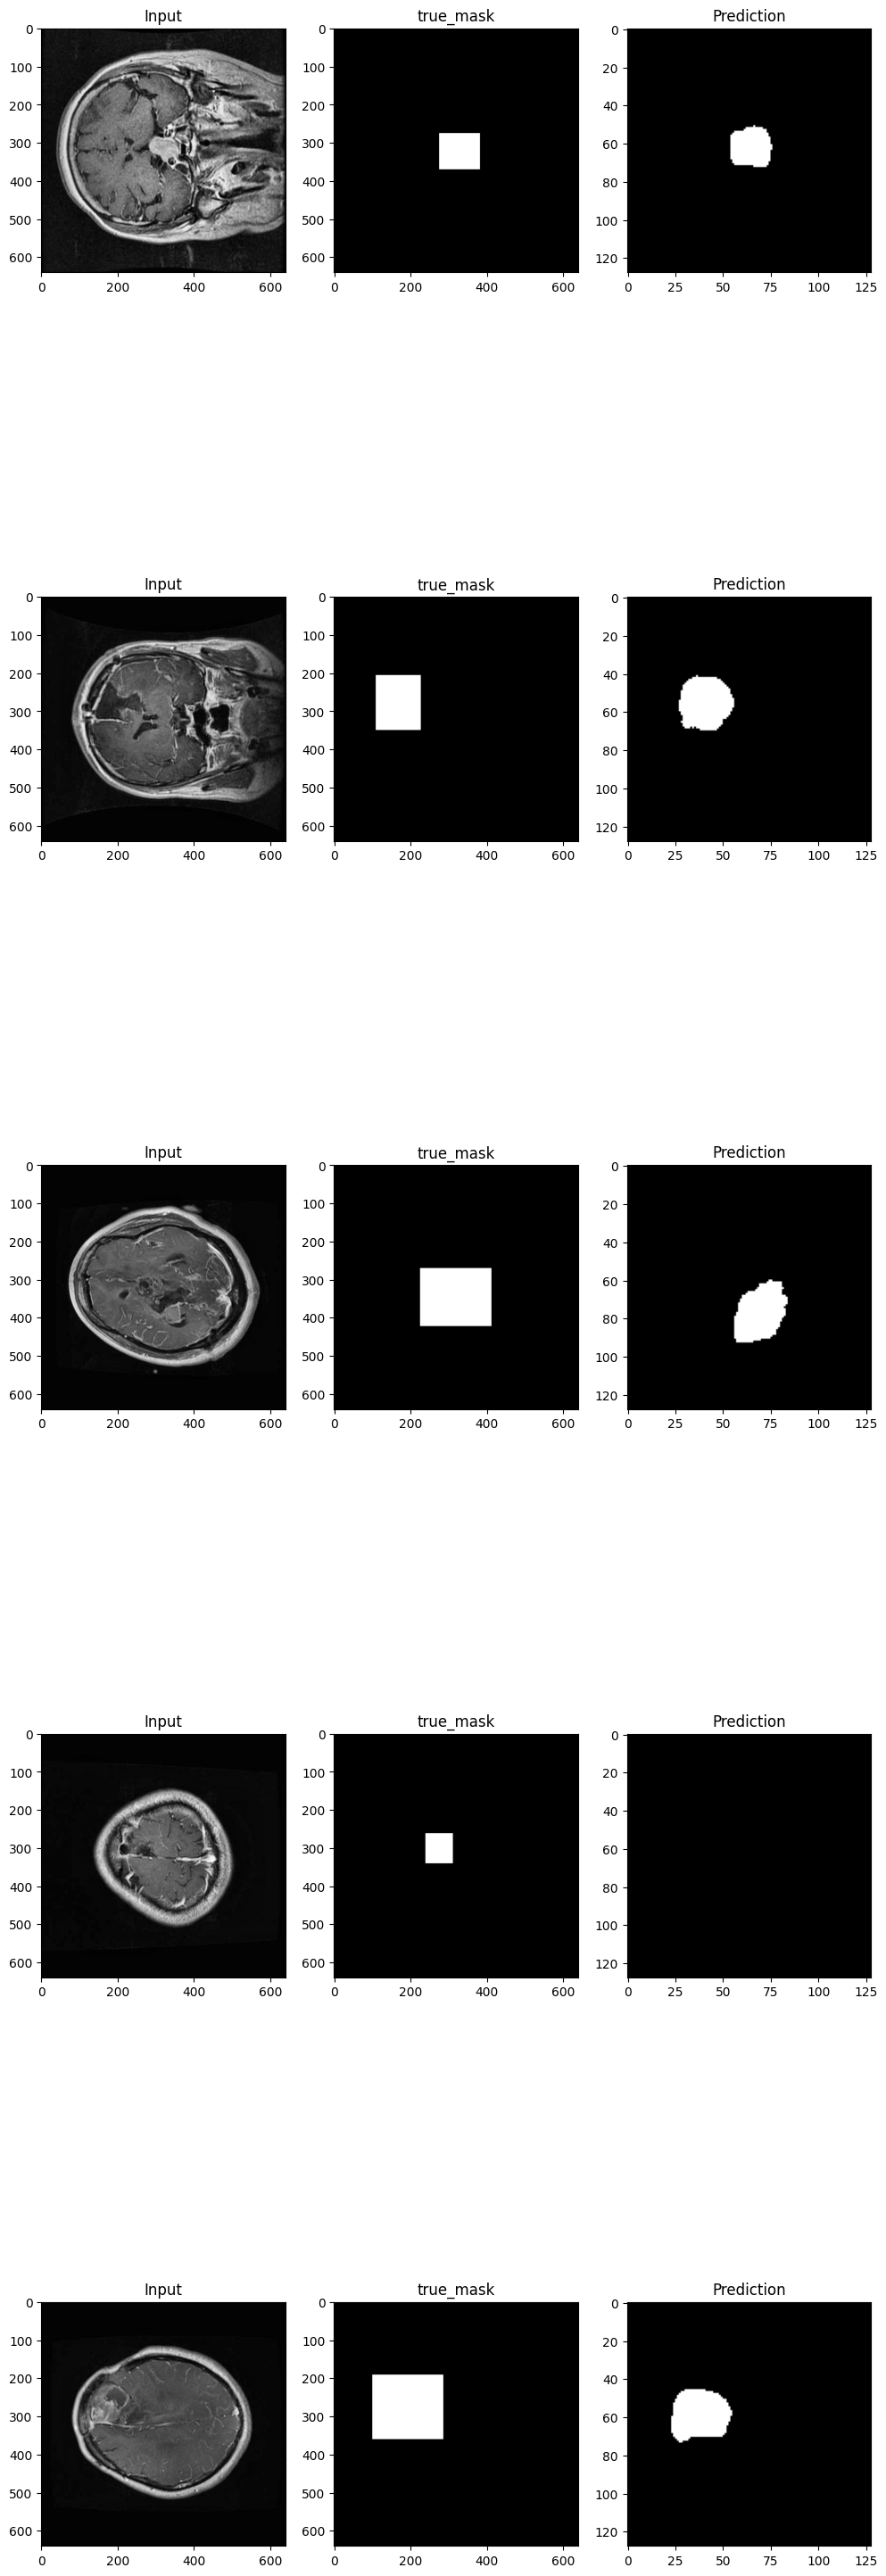

In [ ]:
import matplotlib.pyplot as plt
def test_random_images(n=5):
  # select n random images
  # use cv and plt to show these images
    test_mask_dir = '/kaggle/working/test_masks/'

    indices = np.random.randint(0, len(test_annotation['images']), size=n)

    images =[test_annotation['images'][i] for i in indices ]

    annotations = [test_annotation['annotations'][i] for i in indices ]
    j=1
    plt.figure(figsize=(12, 4 * 2 * n))
    for img,ann in zip(images,annotations):
        plt.subplot(n,3,j)
        j+=1
        image = cv2.imread(test_path + img['file_name'])

        plt.imshow(image)
        plt.title("Input")
        mask = predict(test_path + img['file_name'],unet_model)

        result_image = np.zeros((128, 128,1), dtype=np.uint8)
        result_image[mask == 1] = 255

        true_mask = cv2.imread(test_mask_dir + img['file_name'])
        plt.subplot(n,3,j)
        j+=1
        plt.imshow(true_mask)
        plt.title("true_mask")

        plt.subplot(n,3,j)
        j+=1
        plt.imshow(result_image,cmap='gray')
        plt.title("Prediction")

test_random_images()